In [1]:
import os
from locale import setlocale
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin,cos,arcsin,sqrt,abs,pi,log10,exp
from scipy.fftpack import fft,ifft
from scipy.io import wavfile
from scipy.stats import gmean 
from tqdm import tqdm
from compress_pickle import dump as cpkldump # reading/writing compressed pickles
from compress_pickle import load as cpklload # reading/writing compressed pickles

#obspy
from obspy import UTCDateTime
from obspy import read
from obspy import read_inventory

from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")

from obspy.core.stream import Stream
from obspy.core.event import read_events
from obspy.core.inventory.inventory import read_inventory
from obspy.core.util import Enum
from obspy.core.inventory.response import ResponseListElement as amplitude
from obspy.core.event.magnitude import StationMagnitude

from obspy.clients.neic import Client as nClient
from obspy.clients.fdsn import Client as fdsnClient

from obspy.geodetics.base import locations2degrees as l2d
from obspy.geodetics.base import degrees2kilometers as d2km
from obspy.geodetics.base import kilometers2degrees as km2d
from obspy.geodetics.base import gps2dist_azimuth as ll2az

from obspy.signal.filter import bandpass

#rtergpy
from rtergpy.run import defaults, event, etime2name, src2ergs
from rtergpy.waveforms import get_respinv, getwaves, loadwaves, process_waves, trstat2pd

#attenuation
from attenuation import processANSS, readANSS, freqmaxes

ModuleNotFoundError: No module named 'attenuation'

In [4]:
# Current method for reading data, need to replace with ANSS processing once I figure out how to use my lil programs.

Defaults=defaults()
Event=event()

Defaults.src ="RASPISHAKE"
src = Defaults.src 

Defaults.network ="AM"
network = Defaults.network

Defaults.chan ="EHZ"
chan = Defaults.chan

Defaults.stationrange=[1.,10.]
rads = Defaults.stationrange

Event.eloc = [18.4578,-73.3389,10]
eloc = Event.eloc

Event.etime = UTCDateTime(2022,1,24,13,16,23.425)
etime = Event.etime

Event.origin =[eloc,etime]
Event.ecount ='00'
Event.iter ='RS'
Event.eventname = etime2name(etime,ecount=Event.ecount)

# getting inventory

inventory = get_respinv(network,eloc,etime,rads,chan,src)
print(inventory)

Inventory created at 2023-06-26T18:31:47.274190Z
	Sending institution: SeisComP (RaspberryShake)
	Contains:
		Networks (1):
			AM
		Stations (28):
			AM.R0306 (Raspberry Shake Citizen Science Station)
			AM.R095E (Raspberry Shake Citizen Science Station)
			AM.R17FC (Raspberry Shake Citizen Science Station)
			AM.R2974 (Raspberry Shake Citizen Science Station)
			AM.R2C45 (Raspberry Shake Citizen Science Station)
			AM.R34A9 (Raspberry Shake Citizen Science Station)
			AM.R4802 (Raspberry Shake Citizen Science Station)
			AM.R4DB9 (Raspberry Shake Citizen Science Station)
			AM.R4EEE (Raspberry Shake Citizen Science Station)
			AM.R54B1 (Raspberry Shake Citizen Science Station)
			AM.R6324 (Raspberry Shake Citizen Science Station)
			AM.R804D (Raspberry Shake Citizen Science Station)
			AM.R976A (Raspberry Shake Citizen Science Station)
			AM.RA08A (Raspberry Shake Citizen Science Station)
			AM.RA887 (Raspberry Shake Citizen Science Station)
			AM.RA9CF (Raspberry Shake Citizen Scienc

In [6]:
# getting waveforms
Event.newData = False  # False means locally stored

if Event.newData:
    print("Getting waveforms")
    #st,df=getwaves(eloc,etime,pwindow=Def.waveparams[1],rads=Def.stationrange)
    st,df=getwaves(Defaults=Defaults,Event=Event)
else:
    print("Loading locally stored waveforms")
    try:
        st,df=loadwaves(Defaults=Defaults,Event=Event) 
    except:
        print("Couldn't load data for "+eventname+". Attempting to download:")
        st,df=getwaves(Defaults=Defaults,Event=Event)
if len(st) == 0:
    raise Exception("ERROR: No waveforms retreived.") 

Loading locally stored waveforms


In [24]:
# filter for instrument response and taper

taper=0.05

stp=st.copy()  # create backup
# process data
stp.detrend(type='polynomial', order=5) # pre-instrument removal
stp.taper(taper)
stp.remove_response(output="DISP")
stp.detrend(type='polynomial', order=5) # post-instrument removal
stp.taper(taper)

9 Trace(s) in Stream:
AM.R0306.00.EHZ | 2022-01-24T13:15:43.425999Z - 2022-01-24T13:21:43.425999Z | 100.0 Hz, 36001 samples
AM.R2974.00.EHZ | 2022-01-24T13:16:51.211999Z - 2022-01-24T13:22:51.211999Z | 100.0 Hz, 36001 samples
AM.R34A9.00.EHZ | 2022-01-24T13:17:00.989999Z - 2022-01-24T13:23:00.989999Z | 100.0 Hz, 36001 samples
AM.R4DB9.00.EHZ | 2022-01-24T13:16:54.835000Z - 2022-01-24T13:22:54.835000Z | 100.0 Hz, 36001 samples
AM.RA08A.00.EHZ | 2022-01-24T13:16:08.553000Z - 2022-01-24T13:22:08.553000Z | 100.0 Hz, 36001 samples
AM.RA9CF.00.EHZ | 2022-01-24T13:17:02.590000Z - 2022-01-24T13:23:02.590000Z | 100.0 Hz, 36001 samples
AM.RD17E.00.EHZ | 2022-01-24T13:16:52.256999Z - 2022-01-24T13:22:52.256999Z | 100.0 Hz, 36001 samples
AM.RD4D8.00.EHZ | 2022-01-24T13:16:06.957000Z - 2022-01-24T13:21:59.197000Z | 100.0 Hz, 35225 samples
AM.RE001.00.EHZ | 2022-01-24T13:16:27.183000Z - 2022-01-24T13:22:27.183000Z | 100.0 Hz, 36001 samples

In [2]:
# process each individual frequency band in a bandpass using .filter
# frequency bands of 0.1-0.25, 0.25-0.5, 0.5-0.75, 0.75-1, 1-1.5

freqs = ([0.1,0.25],[0.25,0.5],[0.50,0.75],[0.75,1],[1,1.25])

# freq1 band = 0.1-0.25,
stp_freq1 = stp.copy()
stp_freq1.filter("bandpass",freqmin=0.10 , freqmax=0.25)

# freq2 band = 0.25-0.5,
stp_freq2 = stp.copy()
stp_freq2.filter("bandpass", freqmin=0.25, freqmax=0.50)

# freq3 band = 0.5-0.75,
stp_freq3 = stp.copy()
stp_freq3.filter("bandpass", freqmin=0.50, freqmax=0.75)

# freq4 band = 0.75-1.
stp_freq4 = stp.copy()
stp_freq4.filter("bandpass", freqmin=0.75, freqmax=1.0)

# freq5 band = 1-1.25
stp_freq5 = stp.copy()
stp_freq5.filter("bandpass", freqmin=1, freqmax=1.25)

#add all freq to a tuple
stp_freqs = (stp_freq1,stp_freq2,stp_freq3,stp_freq4,stp_freq5)

NameError: name 'stp' is not defined

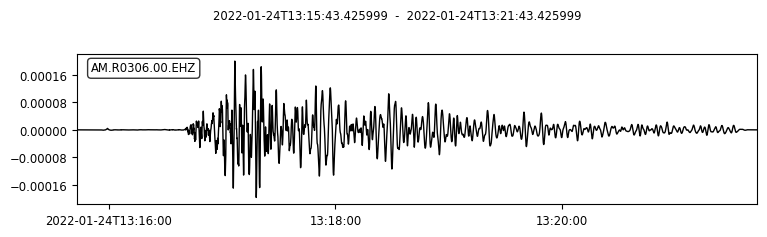

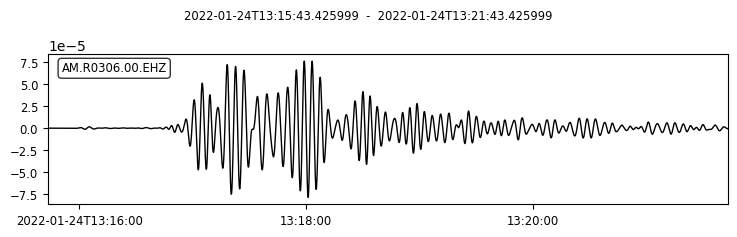

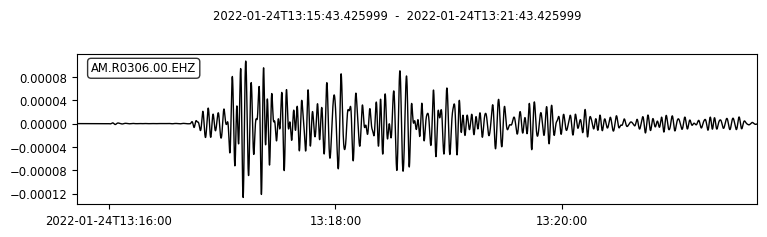

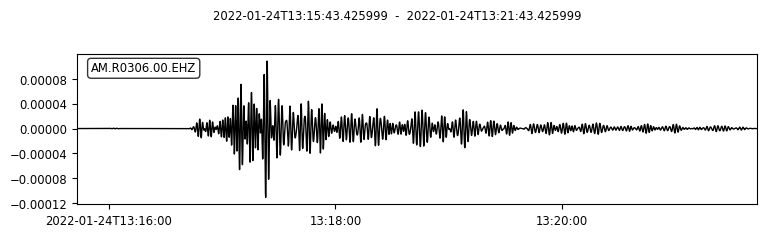

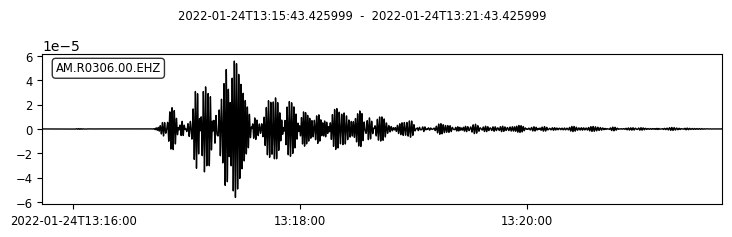

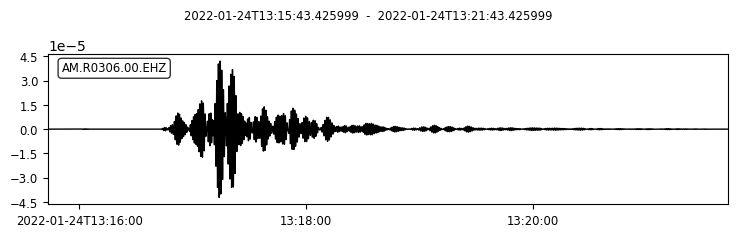

In [26]:
# Plot all the wiggles, shows how frequency filtering works. 

stp[0].plot(); #only instrument response removal
stp_freq1[0].plot(); # bandpass filter of 0.1-0.25
stp_freq2[0].plot(); # bandpass filter of 0.25-0.5
stp_freq3[0].plot(); # bandpass filter of 0.5-0.75
stp_freq4[0].plot(); # bandpass filter of 0.75-0.1
stp_freq5[0].plot(); # bandpass filter of 1-1.25

In [1]:
# use freqmaxes function to get maxamps for all traces in one frequency band
# compare the plots formed from the function above with previous tests in Appendix below

ALLmaxamps, ALLidx_of_max_amps = [], []

for st in stp_freqs:

    for tr in st:
        
        # print(f"Now processing trace {tr}")
        maxamps, idx_of_max_amps = freqmaxes(tr, freqs)
        # print(maxamps, idx_of_max_amps) # to test if it worked
        ALLmaxamps.append(maxamps)
        ALLidx_of_max_amps.append(idx_of_max_amps)
        # trname.append(tr)  # no need to save this...it'll get huuuuuuuge
        # stname.append(st)
       
pandadf = pd.DataFrame({"maxamps":ALLmaxamps, "idx of max amps":ALLidx_of_max_amps}) 
pandadf

NameError: name 'stp_freqs' is not defined

In [ ]:
print(trname)

[<obspy.core.trace.Trace object at 0x11026acd0>, <obspy.core.trace.Trace object at 0x110294410>, <obspy.core.trace.Trace object at 0x1743e3ad0>, <obspy.core.trace.Trace object at 0x174408610>, <obspy.core.trace.Trace object at 0x17440c510>, <obspy.core.trace.Trace object at 0x174410590>, <obspy.core.trace.Trace object at 0x1744105d0>, <obspy.core.trace.Trace object at 0x174417fd0>, <obspy.core.trace.Trace object at 0x174420050>, <obspy.core.trace.Trace object at 0x1743c2cd0>, <obspy.core.trace.Trace object at 0x1744134d0>, <obspy.core.trace.Trace object at 0x17442df10>, <obspy.core.trace.Trace object at 0x174435d50>, <obspy.core.trace.Trace object at 0x174439b90>, <obspy.core.trace.Trace object at 0x174441c10>, <obspy.core.trace.Trace object at 0x174449450>, <obspy.core.trace.Trace object at 0x1744551d0>, <obspy.core.trace.Trace object at 0x174459010>, <obspy.core.trace.Trace object at 0x17441b4d0>, <obspy.core.trace.Trace object at 0x1744363d0>, <obspy.core.trace.Trace object at 0x174

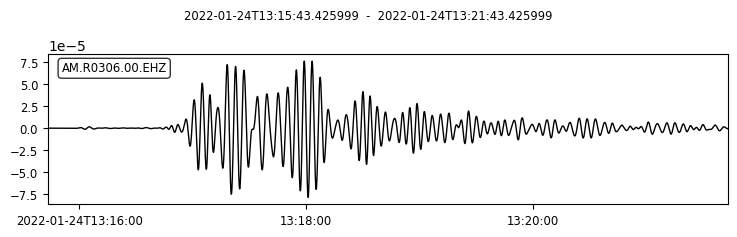

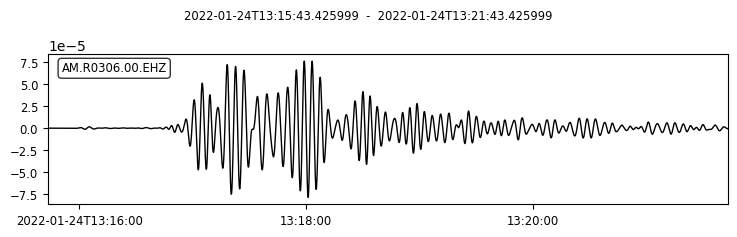

In [ ]:
pandadf["trace"][0].plot()